# 09_Simple-MLP-unsupervised-prune


In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.simple_pruning_growth_model import DrLIMPruneGrowNetwork, ContrastiveLoss, constrative_test_loop
from src.training_testing_loop import full_train, save_model_attr, format_training_outputs
from src.load_MNIST import get_mnist_pairs_loader
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

In [10]:
train_pair_dataloader, val_pair_dataloader = get_mnist_pairs_loader(
    batch_size=32, train=True, subset_fraction=0.05, validation_ratio=6, seed=42, 
    selected_labels=[4, 9]
)
test_pair_dataloader = get_mnist_pairs_loader(batch_size=32, train=False, subset_fraction=0.05,  selected_labels=[4, 9])

In [11]:
train_pair_dataloader.dataset.dataset.pair_labels.shape

(1178,)

Pruning, linear prediction activation

In [13]:
DrLIM_model = DrLIMPruneGrowNetwork(
    gamma=0.1, init_density=0.5, num_training_iter=100,
    low_mapping_dim=2, prediction_act=lambda x: x, use_grow_prune_prob=True
)

contrastive_loss_fn = ContrastiveLoss(m=0.2) # if I am using tanh, range is between -1 and 1.
val_contrastive_loss_fn = ContrastiveLoss(m=0.2, reduction='sum')

train_losses_epoch, val_losses_epoch, test_df = full_train(
    DrLIM_model, train_pair_dataloader, val_pair_dataloader, test_pair_dataloader,
    learning_rate = 1e-3, 
    loss_fn=contrastive_loss_fn,
    val_loss_fn=val_contrastive_loss_fn,
    plot=False, verbose=False,
    test_loop_func=constrative_test_loop,
    margin=contrastive_loss_fn.m,
    args_expand=True,
)

Epochs: 100%|██████████| 100/100 [44:37<00:00, 26.77s/it]


In [15]:
stack_training_losses_df, stack_val_losses_df = format_training_outputs(train_losses_epoch, val_losses_epoch)

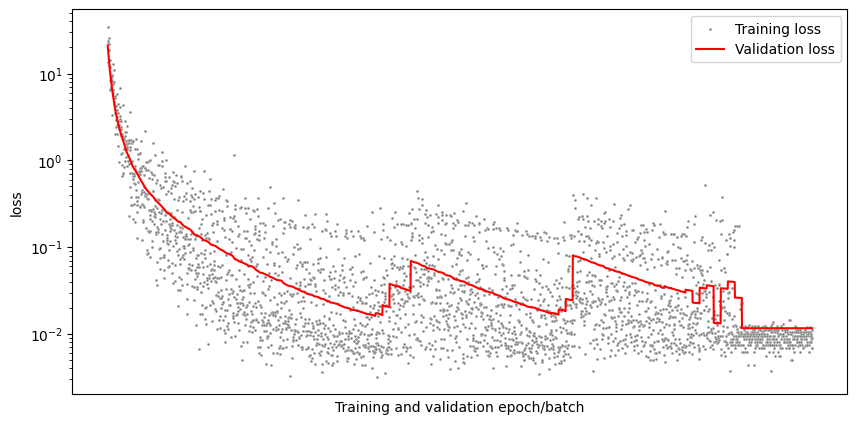

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(stack_training_losses_df.reset_index(), x='index', y='loss', label='Training loss', alpha=1.0, c='gray', s=4, ax=ax)
sns.lineplot(stack_val_losses_df.reset_index(), x='index', y='loss',  label='Validation loss', c='red', ax=ax)
plt.xticks([])
plt.xlabel('Training and validation epoch/batch')
plt.yscale('log')
plt.show()

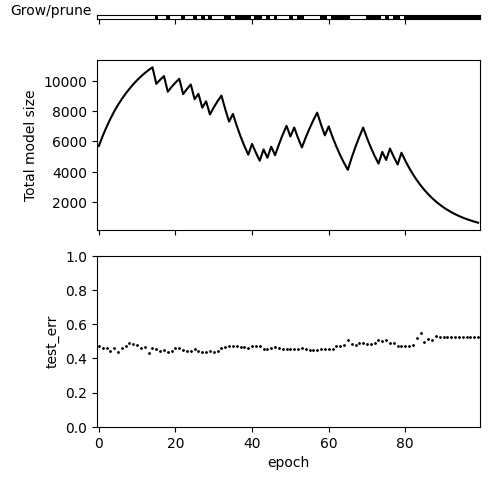

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(5, 5), sharex=True, height_ratios=[1, 5, 5])
axes[0].imshow(np.array(np.array(DrLIM_model.grow_prune_history).reshape(1, -1)), cmap='gray')
axes[0].set_yticks([])
axes[0].set_ylabel("Grow/prune", rotation=0, ha='right')

axes[1].plot(DrLIM_model.synapse_count_history, c='k') 
axes[1].set_ylabel("Total model size")

sns.scatterplot(test_df.reset_index(), x='epoch', y='test_err', ax=axes[2], c='k', s=5) 
axes[2].set_ylim(0, 1.0)
plt.tight_layout()
plt.show()


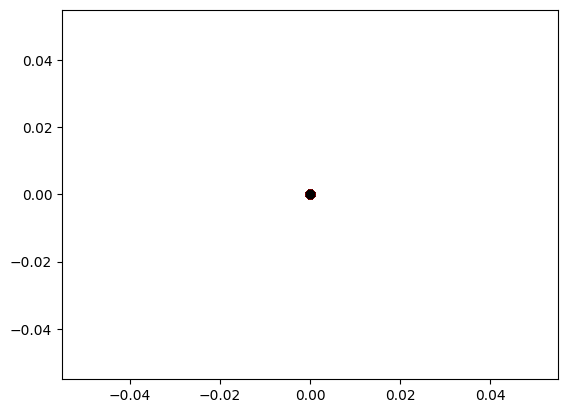

In [19]:
DrLIM_model.eval()
colors = {1: 'ro--', 0: 'ko--'}
with torch.no_grad():
    for X, y in train_pair_dataloader:
        pred = DrLIM_model(X)
        for i in range(len(pred[0])):
            plt.plot([pred[0][i, 0], pred[1][i, 0]], [pred[0][i, 1], pred[1][i, 1]], colors[y[i].item()])
    plt.show()

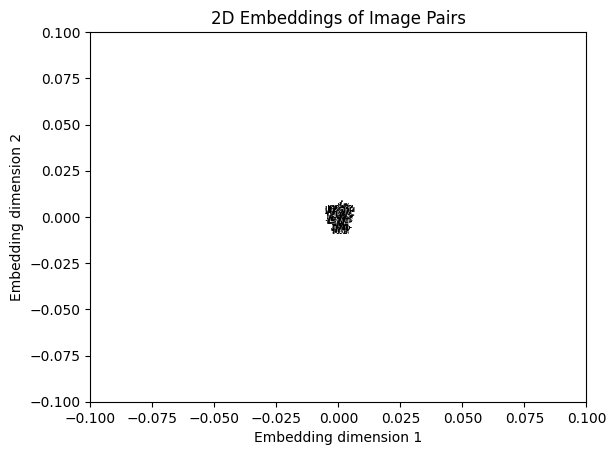

In [22]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

DrLIM_model.eval()
colors = {1: 'red', 0: 'black'}  # Solid colors for points
line_styles = {1: 'r--', 0: 'k--'}  # Dashed lines for connections
fig, ax = plt.subplots()

ax.set_xlabel('Embedding dimension 1')
ax.set_ylabel('Embedding dimension 2')
ax.set_title('2D Embeddings of Image Pairs')
ax.set_ylim(-.1, .1)
ax.set_xlim(-.1, .1)

def plot_img_embedding(img, x, y):
    img[img < -0.1] = np.nan
    im = OffsetImage(img, cmap='gray_r', zoom=1.0)
    return AnnotationBbox(im, (x, y), xycoords='data', frameon=False)

with torch.no_grad():
    artists = []
    for X, y in train_pair_dataloader:
        pred = DrLIM_model(X)

        for i in range(len(pred[0])):
            # Plot points for both images in the pair
            # plt.scatter(pred[0][i, 0], pred[0][i, 1], c=colors[y[i].item()], alpha=0.6)
            # plt.scatter(pred[1][i, 0], pred[1][i, 1], c=colors[y[i].item()], alpha=0.6)
            
            ab = plot_img_embedding(X[0][i].permute(1, 2, 0).numpy(), pred[0][i, 0].item(), pred[0][i, 1].item())
            ax.add_artist(ab)

            ab = plot_img_embedding(X[1][i].permute(1, 2, 0).numpy(), pred[1][i, 0].item(), pred[1][i, 1].item())
            ax.add_artist(ab)
            
        break
                
    plt.show()
